## 課題 ボストン住宅価格予測 決定木
https://diver.diveintocode.jp/textbooks/531  
今回の課題は以下の流れで進んでいきます。  
・データ取得  
・データ可視化  
・前処理  
・モデル選択  
・データセット分割  
・グリッドサーチ  
・学習  
・評価  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
%matplotlib inline

### 1. データを取得する / 取得データをDataFrameにする

In [2]:
X = pd.DataFrame(load_boston().data, columns = load_boston().feature_names)
y = pd.DataFrame(load_boston().target, columns = ['MEDV'])
# X.to_csv('boston_datasets.csv')

### 2. データ探索
データ探索を行わないと次のような問題を引き起こす。  
・誤ったモデルの構築  
・誤ったデータに適合してしまったモデルの構築  
・対象のモデルに相応しくない特徴量の選択  
・モデルの構築含め、リソースの非効率な使用  

参考文献: https://indatalabs.com/blog/data-science/datascience-project-exploratory-data-analysis#UhlzZ1qXbrVw4pks.99  

### 3. 基本的なデータ探索
##### ・このデータセットは何のデータセットであるか(何のために作成されたか、誰が作成したか、何年に作成されたか)
###### 答え:
マサチューセッツ州ボストン市内における、住宅価格に影響を与えると考えられる要因を国勢調査のデータから集めたもの  
##### ・何のために作成されたか 
###### 答え:
大気汚染が与える住宅価格への影響を、それ以外の要因による住宅価格への影響も含めて分析するために作成されたもの  
##### ・誰が作成したか  
###### 答え:
David Harrsion, Jr: ハーバード大学、ケンブリッジ大学の都市計画学部の教授  
Daiel L. Riubinfeld: ミシガン大学の経済学部と公共政策研究所の教授  
##### ・何年に作成されたか  
##### 答え:
1978年  

参考文献:  
https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

https://poseidon01.ssrn.com/delivery.php?ID=072078126116072113107031124066097086050045038009039013023072068120021103018096067104039124063013051027109080068002120000016013039057093013053121023013098092003113011041026009020097017124095067073073084097007092011076091025076013087088024102004116120013&EXT=pdf

https://www.law.berkeley.edu/files/Hedonic.PDF

##### ・それぞれのカラムは何を表しているのか
###### 答え:
- CRIM: 地区単位の、人口一人当たりの犯罪発生率  
- ZN: 25,000平方フィート以上の敷地面積のある住宅の割合  
- INDUS: 地区単位の、小売店を除く商業施設の割合  
- CHAS: チャールズ川周辺(境界)地区とそうでない地区で環境汚染が異なるかを知るために利用する情報(「1」ならチャールズ川周辺、「0」ならそれ以外)。気象モデル(meterological model(TASSIM))を使用して計測した、チャールズ川境界線地区とそうでない地区の環境汚染率の最大値(予測値含む) 
- NOX:  1,000万単位の、酸化窒素濃度  
- RM: 一つの住居単位の、平均部屋数  
- AGE: 1940年以前に建てられて建物のうち、建物所有者自身が利用している割合  
- DIS: ボストンにある五つの雇用センターへの加重平均した距離  
- RAD: 市内から放射状に広がる高速道路へのアクセスのしやすさ(指標)  
- TAX: 10,000ドル単位の、固定資産税の税率の最大値  
- PTRATIO: 地区単位の、生徒と先生の比率  
- B: ある一定エリア(警察管轄?)単位の、黒人の比率。算式は、(「地区単位の黒人の比率」 - 0.63)の2乗  
- LSTAT: ある一定エリア(警察管轄?)単位の、低所得者の割合。
- MEDV: 1,000ドル単位の、建物所有者が利用する住居のメジアン値(中央値)  

補足:  
参考文献中、「by town」は地区単位とし、Boston市内をさらに分割する地域と捉えた、「in tract」は一定エリア(警察管轄?)単位とし、地区内をさらに分割する地域と捉えた

### 4. 一変数の可視化
(一変数の可視化: 生データセットの各フィールドの要約統計情報を提供)

In [3]:
stats_X = X.describe()
stats_y = y.describe()
stats_value = pd.concat([stats_X, stats_y], axis = 1)  # 'axis = 1' removes NaN１
stats_value
# stats_value.to_csv('stats_value.csv')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### 5. describeメソッドを用いることで把握できたこと(考察)を記述せよ
##### 以下の観点をすべて含めて記述しましょう。
###### 答え:
NOX(酸化窒素濃度)の最小値と最大値の開きが少なため、大気汚染の進行状態が地区単位で明確(強弱)にならないように感じた。  
ZNはカテゴリデータのため、他のデータと扱い方を変えるべきではないかと感じた。  
##### ・前処理に関して気をつけるべき点
###### 答え:
データの単位がまちまちな値になっているため、統一する必要がある。  
例えば、NOXは「1」以下の数値だが、TAXは100桁の数値になっているため、単位を揃える必要がある。
また、外れ値を扱い方を決める必要がある。
例えば、CRIMは第３四分位数まで、「3.65」程度だが、第３四分位から最大値までが、「85」の開きがある。  
このmaxが「88.976」のデータは、外れ値の可能性があり、何かしらの処理をする必要がある。  
平均値と標準偏差が与えられているため、そこから「95%」の範囲に入らないデータを外れ値とし、そのデータに対し学習しないよう、除外しておくことも考えられる。  
##### ・機械学習の手法選択に活かせること
###### 答え:
連続的な値をとる特徴量が多い場合は回帰的な手法、カテゴリ的な値をとる特徴量の場合はクラス分類を選ぶための指針になる。  
##### ・機械学習の特徴選択について考えられること
###### 答え:
それぞれ、最小値、第１四分位数、中央値、第３四分位数、最大値の間隔が似ている特徴量同士は、強い相関関係があるかもしれないと推測できる。  

### 5. 二変数の可視化
#### 二変数の可視化　相関

In [4]:
y['MEDV'].corr(X['LSTAT'])

-0.73766272617401474

###### y['MEDV']との相関関係 の結果 
> 対CRIM: -0.38583168988399047  
 対ZN:   0.36044534245054333  
 対INDUS: -0.48372516002837285  
 対CHAS: 0.17526017719029818  
 対NOX:  -0.42732077237328242  
 対RM:   0.69535994707153903  
 対AGE: -0.37695456500459601  
 対DIS:  0.24992873408590388  
 対RAD:  -0.38162623063977746  
 対TAX:  -0.4685359335677669  
 対PTRATIO: -0.50778668553756146  
 対B:   0.33346081965706637  
 対LSTAT: -0.73766272617401474  

#### 二変数の可視化について記述せよ　相関
##### ・そもそも相関とは何か
###### 答え:
二つ以上の特徴量(変量)がある場合において、一つ特徴量の値に対するその他の特徴量の比例度合いを表すこと  
##### ・MEDVにもっとも相関があると出力された変数を３つあげよ
###### 答え:
1. LSTAT: 相関係数は、「-0.73766272617401474」(負の相関)  
2. RM:    相関係数は、「 0.69535994707153903」(正の相関)  
3. INDUS: 相関係数は、「-0.48372516002837285」(負の相関)  
##### ・相関がある変数を判明させることでどのように利用できそうか考察せよ（調査せよ）
###### 答え:
精度の高い予測ができるモデルを構築することができそう  

#### 相関の注意点について記述せよ
##### ・相関が正しく2変数の関係を表していない時がある、それはどのような場合か
###### 答え:
無相関のとき  
##### ・その場合、どのような手段によって、確認するべきか
###### 答え:
相関係数が「0」に近いとき  
#### 二変数の可視化　プロット

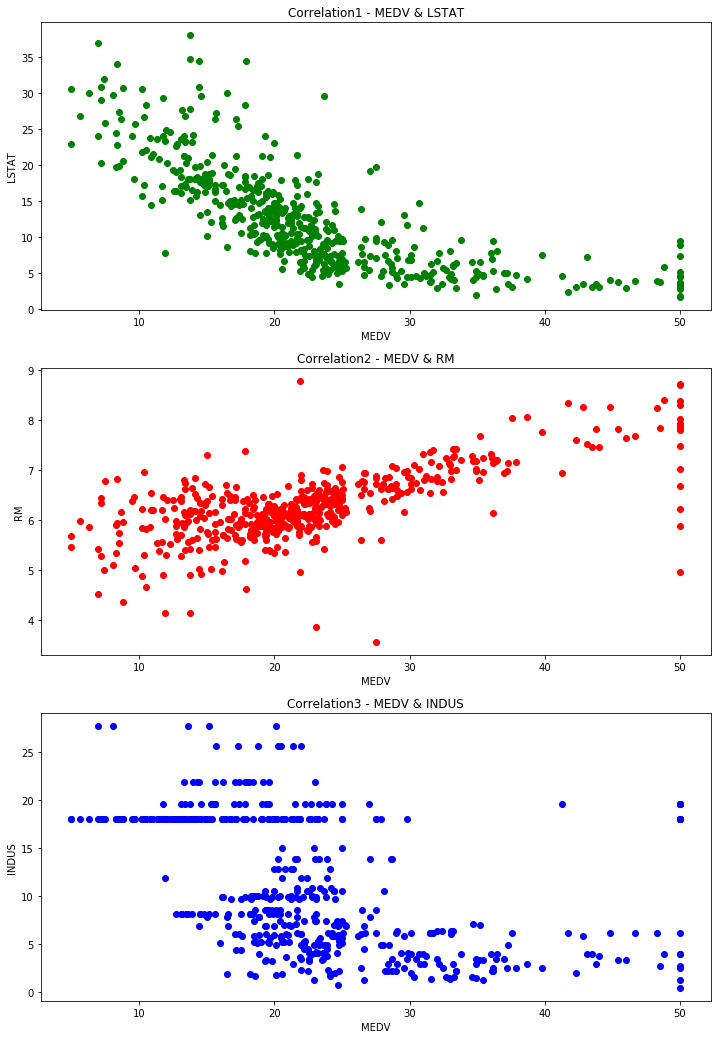

In [5]:
plt.figure(figsize = (12, 18))
plt.subplot(3,1,1)
plt.title("Correlation1 - MEDV & LSTAT")
plt.scatter(y, X["LSTAT"], color = "g")
plt.xlabel("MEDV")
plt.ylabel("LSTAT")
plt.subplot(3,1,2)
plt.title("Correlation2 - MEDV & RM")
plt.scatter(y, X["RM"], color = "r")
plt.xlabel("MEDV")
plt.ylabel("RM")
plt.subplot(3,1,3)
plt.title("Correlation3 - MEDV & INDUS")
plt.scatter(y, X["INDUS"], color = "b")
plt.xlabel("MEDV")
plt.ylabel("INDUS")

#### 二変数の可視化について記述せよ　プロット
###### 答え:
プロット図の通り、それぞれの特徴量同士、相関関係があることを確認できる。    
特に、MEDVとLSTATは負の相関、MEDVとRMは正の相関がはっきりと現れていることが確認できる。

### 6. データセット分割 / 学習 / 決定係数

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
for d in range(3):
    tree = DecisionTreeRegressor(max_depth = d + 1)
    tree.fit(X_train, y_train)
    print("Test  score", d + 1, ": {}".format(tree.score(X_test, y_test)))

Test  score 1 : 0.3602156982888398
Test  score 2 : 0.645549571073612
Test  score 3 : 0.8158427804142425


### 7. 学習曲線

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

Automatically created module for IPython interactive environment


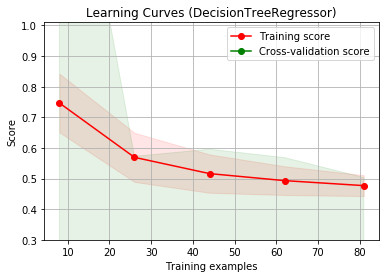

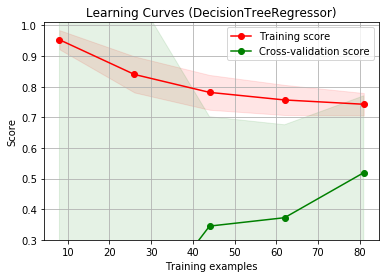

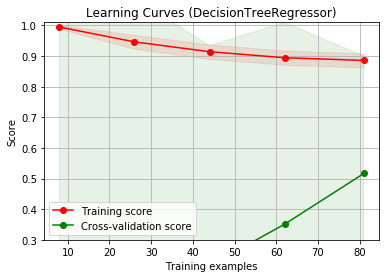

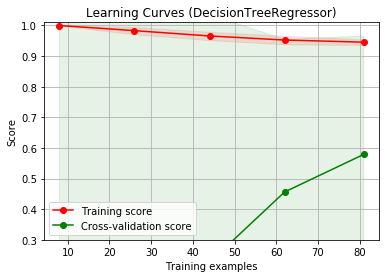

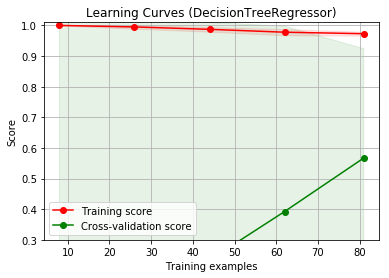

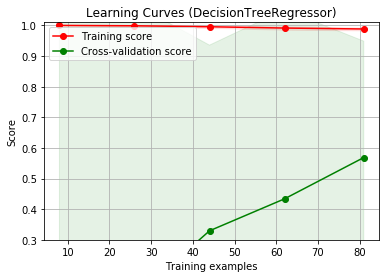

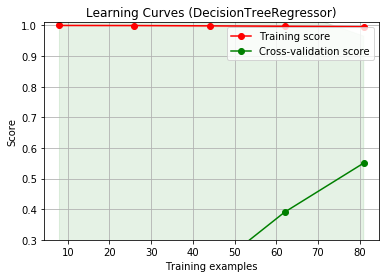

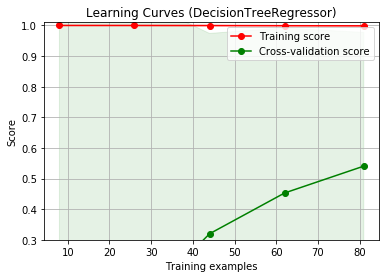

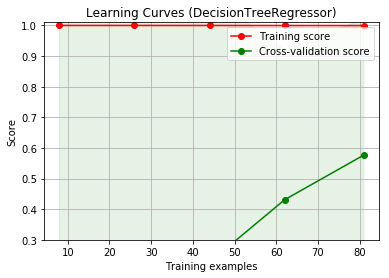

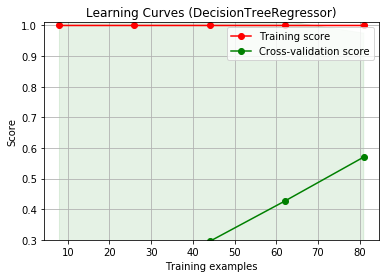

In [8]:
print(__doc__)
title = "Learning Curves (DecisionTreeRegressor)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=1)
for degree in range(1,11):
    estimator = DecisionTreeRegressor(max_depth=degree)
    plot_learning_curve(estimator, title,X_test, y_test, ylim=(0.3, 1.01), cv=cv, n_jobs=4)

### 8. 学習曲線について記述せよ
##### ・High varianceとは何か
###### 答え:
High Varianceとは過学習が起きていること  
次元が低い時に発生しやすい
##### ・High Biasとは何か
###### 答え:
High biasとはアンダーフィット(適合不足)が起きていること  
次元が高い時に発生しやすい  
##### ・もっとも結果が良いと思われた深さをひとつ選択せよ
###### 答え:
9
##### ・なぜその深さが最も良いか記述せよ
###### 答え:
Training Scoreが最も高い(Scoreが限りなく「１」に近い)中で、Cross Validation Scoreが高かった(0.58程度)から
##### ・その最も結果が良いと思われる深さにおいて、データ数を増やしていくと、さらに結果は良くなるか記述せよ
###### 答え:
良くなるとは考えにくい。  
なぜなら、Cross Validation Scoreがまだ低く、現状のデータセットで改善する余地があると考えられるから。  

参考文献:  https://followthedata.wordpress.com/2012/06/02/practical-advice-for-machine-learning-bias-variance/

### 9. グリッドサーチ

In [9]:
tree = DecisionTreeRegressor()
params = {"max_depth": list(range(1, 11))}
scoring_fnc = make_scorer(r2_score)
grid_r2_5 = GridSearchCV(estimator = tree, param_grid = params, scoring = scoring_fnc, cv = 5)
grid_r2_5.fit(X_train, y_train)
print(grid_r2_5.best_params_)

{'max_depth': 8}


### 10. グリッドサーチについて記述せよ
##### ・グリッドサーチとは何か
###### 答え:
最も最良な汎化性能を引き出すためのパラメータ値を見つける手法で、全てのパラメータの組み合わせを試行する手法
##### ・グリッドサーチと同じようにハイパーパラメーターを探索する手法を挙げよ
###### 答え:
ランダムサーチ
##### ・その手法は、グリッドサーチと比べて、どの点で優れているか、どのように使い分けるべきか
###### 答え:
グリッドサーチと比べて少ない計算時間で結果を得ることができる。  
したがって、限られた時間内で、非常に多いハイパーパラメータの組み合わせを計算する場合は、ランダムサーチを使うことも検討すべきである。  

参考文献: https://www.pyimagesearch.com/2016/08/15/how-to-tune-hyperparameters-with-python-and-scikit-learn/

### 11. グリッドサーチを使いこなそう
##### ・グリッドサーチの際、Kfoldの折りたたみの回数を5回と設定しているが、それぞれ3回と10回に変えて検証せよ、また結果を元にどの折りたたみ回数がベストなのか考察せよ

In [10]:
tree = DecisionTreeRegressor()
params = {"max_depth": list(range(1, 11))}
scoring_fnc = make_scorer(r2_score)
grid_r2_3 = GridSearchCV(estimator = tree, param_grid = params, scoring = scoring_fnc, cv = 3)
grid_r2_3.fit(X_train, y_train)
print("KFold is 3 - ", grid_r2_3.best_params_)

tree = DecisionTreeRegressor()
params = {"max_depth": list(range(1, 11))}
scoring_fnc_10 = make_scorer(r2_score)
grid_r2_10 = GridSearchCV(estimator = tree, param_grid = params, scoring = scoring_fnc, cv = 10)
grid_r2_10.fit(X_train, y_train)
print("KFold is 10- ", grid_r2_10.best_params_)

KFold is 3 -  {'max_depth': 9}
KFold is 10-  {'max_depth': 9}


##### ・グリッドサーチにおいて評価方法を決定係数を使用していたが、平均二乗誤差に変更せよ

In [11]:
tree = DecisionTreeRegressor()
params = {"max_depth": list(range(1, 11))}
# scoring_fnc = make_scorer(r2_score)
grid_mse_5 = GridSearchCV(estimator = tree, param_grid = params, scoring = "neg_mean_squared_error", cv = 5)
grid_mse_5.fit(X_train, y_train)
print(grid_mse_5.best_params_)

{'max_depth': 7}


### 12. テスト

In [12]:
#  7, 4, 8, 2
tree = DecisionTreeRegressor(max_depth = 7)
tree.fit(X_train, y_train)
print("max_depth = 7: ", tree.score(X_test, y_test))
tree = DecisionTreeRegressor(max_depth = 7)
tree.fit(X_train, y_train)
print("max_depth = 4: ", tree.score(X_test, y_test))
tree = DecisionTreeRegressor(max_depth = 7)
tree.fit(X_train, y_train)
print("max_depth = 8: ", tree.score(X_test, y_test))
tree = DecisionTreeRegressor(max_depth = 7)
tree.fit(X_train, y_train)
print("max_depth = 2: ", tree.score(X_test, y_test))

max_depth = 7:  0.78844533974
max_depth = 4:  0.861177888251
max_depth = 8:  0.796315463776
max_depth = 2:  0.875056959385


###### 木の深さ「2」と「4」で「0.8」以上